# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

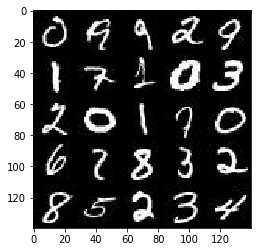

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

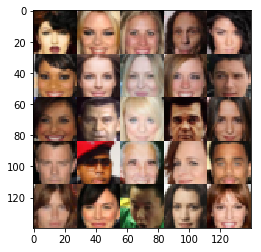

In [3]:
show_n_images = 30

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # images: 28 x 28 x  1or3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(bn2, 224, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4 * 4* 224))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.85
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 4 * 4 * 448)
        x1 = tf.reshape(x1, (-1, 4, 4, 448))
        x1 = tf.nn.dropout(x1, keep_prob)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 224, 5, strides=2, padding='same')
        x2 = tf.nn.dropout(x2, keep_prob)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 112, 5, strides=2, padding='same')
        x3 = tf.nn.dropout(x3, keep_prob)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
    # apply resize
    #   https://nd101.slack.com/archives/C3QVCQHGW/p1494698401613825?thread_ts=1494697166.543980&cid=C3QVCQHGW
    return tf.image.resize_images(out, (28, 28))


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #image_channels = len(data_image_mode)
    image_w, image_h, image_channels = data_shape[1:]
    
    real_input_images, z_data, l_rate = model_inputs(image_w, image_h, image_channels, z_dim)
    d_loss, g_loss = model_loss(real_input_images, z_data, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={real_input_images: batch_images, z_data: batch_z, l_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real_input_images: batch_images, z_data: batch_z, l_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({real_input_images: batch_images, z_data: batch_z})
                    train_loss_g = g_loss.eval({z_data: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    n_images = 25
                    show_generator_output(sess, n_images, z_data, image_channels, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0698... Generator Loss: 0.5513
Epoch 1/2... Discriminator Loss: 3.3252... Generator Loss: 0.0539
Epoch 1/2... Discriminator Loss: 3.0433... Generator Loss: 0.1016
Epoch 1/2... Discriminator Loss: 1.8111... Generator Loss: 0.3582
Epoch 1/2... Discriminator Loss: 1.0018... Generator Loss: 0.6756
Epoch 1/2... Discriminator Loss: 1.0419... Generator Loss: 1.1044
Epoch 1/2... Discriminator Loss: 0.8421... Generator Loss: 1.3746
Epoch 1/2... Discriminator Loss: 0.7893... Generator Loss: 1.7418
Epoch 1/2... Discriminator Loss: 0.8905... Generator Loss: 2.1418
Epoch 1/2... Discriminator Loss: 0.8927... Generator Loss: 2.0507


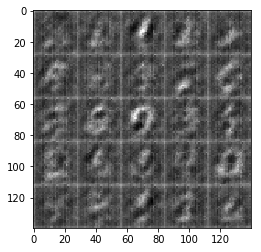

Epoch 1/2... Discriminator Loss: 1.1827... Generator Loss: 2.2836
Epoch 1/2... Discriminator Loss: 1.1642... Generator Loss: 2.4594
Epoch 1/2... Discriminator Loss: 1.0272... Generator Loss: 1.8924
Epoch 1/2... Discriminator Loss: 1.1145... Generator Loss: 1.9621
Epoch 1/2... Discriminator Loss: 1.4467... Generator Loss: 2.4721
Epoch 1/2... Discriminator Loss: 1.3284... Generator Loss: 2.3108
Epoch 1/2... Discriminator Loss: 0.9505... Generator Loss: 1.5813
Epoch 1/2... Discriminator Loss: 1.0471... Generator Loss: 2.0143
Epoch 1/2... Discriminator Loss: 0.9933... Generator Loss: 1.6779
Epoch 1/2... Discriminator Loss: 1.0252... Generator Loss: 1.7811


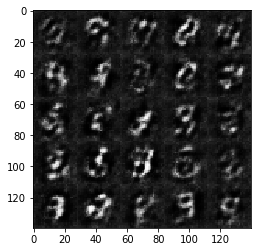

Epoch 1/2... Discriminator Loss: 0.9484... Generator Loss: 2.0753
Epoch 1/2... Discriminator Loss: 1.0110... Generator Loss: 2.0617
Epoch 1/2... Discriminator Loss: 1.1474... Generator Loss: 2.2519
Epoch 1/2... Discriminator Loss: 1.0764... Generator Loss: 2.2965
Epoch 1/2... Discriminator Loss: 0.8174... Generator Loss: 1.8327
Epoch 1/2... Discriminator Loss: 0.8961... Generator Loss: 1.7403
Epoch 1/2... Discriminator Loss: 0.9339... Generator Loss: 2.0137
Epoch 1/2... Discriminator Loss: 0.7321... Generator Loss: 1.4547
Epoch 1/2... Discriminator Loss: 0.8868... Generator Loss: 1.7909
Epoch 1/2... Discriminator Loss: 0.9949... Generator Loss: 2.0719


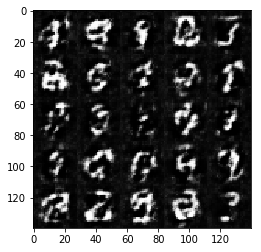

Epoch 1/2... Discriminator Loss: 0.9577... Generator Loss: 2.2009
Epoch 1/2... Discriminator Loss: 0.8187... Generator Loss: 2.0502
Epoch 1/2... Discriminator Loss: 1.0936... Generator Loss: 2.3805
Epoch 1/2... Discriminator Loss: 0.8967... Generator Loss: 2.2469
Epoch 1/2... Discriminator Loss: 0.8028... Generator Loss: 2.3335
Epoch 1/2... Discriminator Loss: 0.8390... Generator Loss: 1.9088
Epoch 1/2... Discriminator Loss: 0.9327... Generator Loss: 2.2942
Epoch 1/2... Discriminator Loss: 0.8515... Generator Loss: 2.3349
Epoch 1/2... Discriminator Loss: 0.8642... Generator Loss: 2.0714
Epoch 1/2... Discriminator Loss: 0.7156... Generator Loss: 1.0927


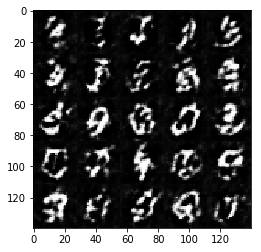

Epoch 1/2... Discriminator Loss: 1.1169... Generator Loss: 0.4859
Epoch 1/2... Discriminator Loss: 0.6569... Generator Loss: 1.1252
Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 0.4661
Epoch 1/2... Discriminator Loss: 0.9082... Generator Loss: 0.5832
Epoch 1/2... Discriminator Loss: 0.7797... Generator Loss: 0.7988
Epoch 1/2... Discriminator Loss: 0.7835... Generator Loss: 0.7826
Epoch 1/2... Discriminator Loss: 0.7601... Generator Loss: 0.8598
Epoch 1/2... Discriminator Loss: 0.7759... Generator Loss: 0.7771
Epoch 1/2... Discriminator Loss: 1.3194... Generator Loss: 0.4087
Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 0.5183


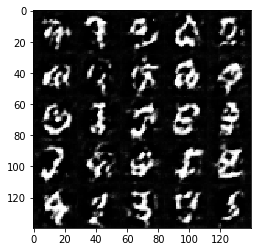

Epoch 1/2... Discriminator Loss: 0.7263... Generator Loss: 0.8853
Epoch 1/2... Discriminator Loss: 0.8609... Generator Loss: 0.6665
Epoch 1/2... Discriminator Loss: 1.0555... Generator Loss: 0.5423
Epoch 1/2... Discriminator Loss: 0.6284... Generator Loss: 1.4102
Epoch 1/2... Discriminator Loss: 0.7458... Generator Loss: 1.6270
Epoch 1/2... Discriminator Loss: 0.7751... Generator Loss: 0.7766
Epoch 1/2... Discriminator Loss: 1.0321... Generator Loss: 0.5394
Epoch 1/2... Discriminator Loss: 0.7903... Generator Loss: 0.7308
Epoch 1/2... Discriminator Loss: 0.9916... Generator Loss: 0.6126
Epoch 1/2... Discriminator Loss: 1.0171... Generator Loss: 0.5297


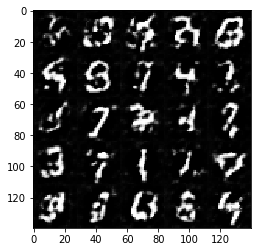

Epoch 1/2... Discriminator Loss: 0.6765... Generator Loss: 1.1882
Epoch 1/2... Discriminator Loss: 0.6345... Generator Loss: 1.6177
Epoch 1/2... Discriminator Loss: 0.7066... Generator Loss: 1.4651
Epoch 1/2... Discriminator Loss: 0.6956... Generator Loss: 1.8198
Epoch 1/2... Discriminator Loss: 0.6823... Generator Loss: 1.6118
Epoch 1/2... Discriminator Loss: 0.9544... Generator Loss: 2.0597
Epoch 1/2... Discriminator Loss: 0.8160... Generator Loss: 1.8009
Epoch 1/2... Discriminator Loss: 1.0189... Generator Loss: 1.9822
Epoch 1/2... Discriminator Loss: 0.6714... Generator Loss: 1.6653
Epoch 1/2... Discriminator Loss: 0.7428... Generator Loss: 2.4434


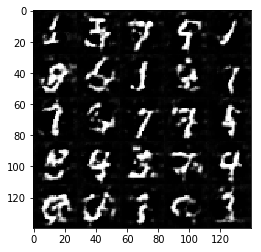

Epoch 1/2... Discriminator Loss: 0.7159... Generator Loss: 1.8538
Epoch 1/2... Discriminator Loss: 0.8070... Generator Loss: 1.9041
Epoch 1/2... Discriminator Loss: 0.7905... Generator Loss: 2.0372
Epoch 1/2... Discriminator Loss: 0.7223... Generator Loss: 1.8831
Epoch 1/2... Discriminator Loss: 0.8485... Generator Loss: 0.7287
Epoch 1/2... Discriminator Loss: 0.9107... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 0.6789... Generator Loss: 2.0315
Epoch 1/2... Discriminator Loss: 0.6550... Generator Loss: 1.6759
Epoch 1/2... Discriminator Loss: 0.8946... Generator Loss: 2.7458
Epoch 1/2... Discriminator Loss: 0.6601... Generator Loss: 1.0693


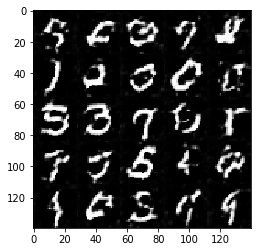

Epoch 1/2... Discriminator Loss: 0.6940... Generator Loss: 0.8859
Epoch 1/2... Discriminator Loss: 0.7440... Generator Loss: 0.9065
Epoch 1/2... Discriminator Loss: 1.0314... Generator Loss: 0.5747
Epoch 1/2... Discriminator Loss: 0.8655... Generator Loss: 0.7106
Epoch 1/2... Discriminator Loss: 0.8400... Generator Loss: 0.7214
Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 0.4903
Epoch 1/2... Discriminator Loss: 0.6461... Generator Loss: 1.1644
Epoch 1/2... Discriminator Loss: 0.9239... Generator Loss: 0.6381
Epoch 1/2... Discriminator Loss: 0.8185... Generator Loss: 0.7288
Epoch 1/2... Discriminator Loss: 1.1542... Generator Loss: 0.4649


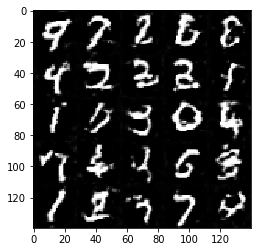

Epoch 1/2... Discriminator Loss: 1.0366... Generator Loss: 0.5926
Epoch 1/2... Discriminator Loss: 0.5777... Generator Loss: 1.1094
Epoch 1/2... Discriminator Loss: 1.2526... Generator Loss: 0.4906
Epoch 2/2... Discriminator Loss: 0.6206... Generator Loss: 1.3230
Epoch 2/2... Discriminator Loss: 0.7856... Generator Loss: 2.2009
Epoch 2/2... Discriminator Loss: 0.6322... Generator Loss: 1.0091
Epoch 2/2... Discriminator Loss: 0.5443... Generator Loss: 1.5797
Epoch 2/2... Discriminator Loss: 0.6397... Generator Loss: 2.1163
Epoch 2/2... Discriminator Loss: 0.5789... Generator Loss: 1.8357
Epoch 2/2... Discriminator Loss: 0.9647... Generator Loss: 0.5725


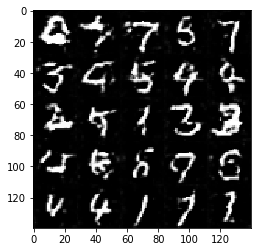

Epoch 2/2... Discriminator Loss: 0.8186... Generator Loss: 0.7474
Epoch 2/2... Discriminator Loss: 0.6775... Generator Loss: 0.9363
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 0.6404
Epoch 2/2... Discriminator Loss: 0.9570... Generator Loss: 2.7092
Epoch 2/2... Discriminator Loss: 0.5260... Generator Loss: 1.4434
Epoch 2/2... Discriminator Loss: 0.5893... Generator Loss: 1.1735
Epoch 2/2... Discriminator Loss: 0.5526... Generator Loss: 1.2082
Epoch 2/2... Discriminator Loss: 0.5323... Generator Loss: 2.0153
Epoch 2/2... Discriminator Loss: 1.0164... Generator Loss: 3.2919
Epoch 2/2... Discriminator Loss: 0.5751... Generator Loss: 1.3070


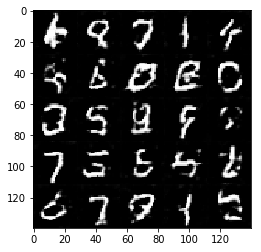

Epoch 2/2... Discriminator Loss: 0.5137... Generator Loss: 2.0247
Epoch 2/2... Discriminator Loss: 0.6221... Generator Loss: 1.3914
Epoch 2/2... Discriminator Loss: 0.5876... Generator Loss: 2.2408
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 1.6836
Epoch 2/2... Discriminator Loss: 0.6480... Generator Loss: 1.0553
Epoch 2/2... Discriminator Loss: 0.7881... Generator Loss: 0.6789
Epoch 2/2... Discriminator Loss: 0.5631... Generator Loss: 1.9548
Epoch 2/2... Discriminator Loss: 0.7795... Generator Loss: 0.7265
Epoch 2/2... Discriminator Loss: 1.1228... Generator Loss: 0.4852
Epoch 2/2... Discriminator Loss: 0.6786... Generator Loss: 0.9535


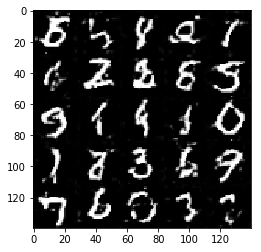

Epoch 2/2... Discriminator Loss: 0.4377... Generator Loss: 2.1923
Epoch 2/2... Discriminator Loss: 0.5295... Generator Loss: 1.2532
Epoch 2/2... Discriminator Loss: 0.7192... Generator Loss: 0.8840
Epoch 2/2... Discriminator Loss: 0.9132... Generator Loss: 0.5961
Epoch 2/2... Discriminator Loss: 2.4391... Generator Loss: 0.1776
Epoch 2/2... Discriminator Loss: 0.6495... Generator Loss: 1.0572
Epoch 2/2... Discriminator Loss: 0.4569... Generator Loss: 1.8348
Epoch 2/2... Discriminator Loss: 0.5171... Generator Loss: 2.6817
Epoch 2/2... Discriminator Loss: 0.5098... Generator Loss: 2.7390
Epoch 2/2... Discriminator Loss: 0.7110... Generator Loss: 2.9877


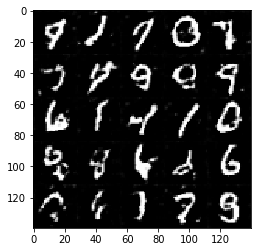

Epoch 2/2... Discriminator Loss: 0.4870... Generator Loss: 1.3624
Epoch 2/2... Discriminator Loss: 0.6814... Generator Loss: 0.8941
Epoch 2/2... Discriminator Loss: 0.4120... Generator Loss: 1.4188
Epoch 2/2... Discriminator Loss: 0.3973... Generator Loss: 1.5955
Epoch 2/2... Discriminator Loss: 0.4746... Generator Loss: 1.2905
Epoch 2/2... Discriminator Loss: 0.6398... Generator Loss: 1.0357
Epoch 2/2... Discriminator Loss: 0.6208... Generator Loss: 1.3722
Epoch 2/2... Discriminator Loss: 0.6163... Generator Loss: 1.0168
Epoch 2/2... Discriminator Loss: 0.4623... Generator Loss: 2.4233
Epoch 2/2... Discriminator Loss: 1.5028... Generator Loss: 4.0278


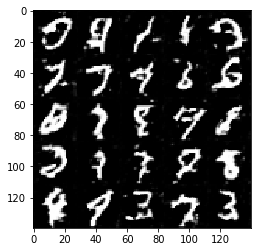

Epoch 2/2... Discriminator Loss: 0.4992... Generator Loss: 2.0124
Epoch 2/2... Discriminator Loss: 0.3983... Generator Loss: 1.7424
Epoch 2/2... Discriminator Loss: 0.4642... Generator Loss: 1.3932
Epoch 2/2... Discriminator Loss: 0.3989... Generator Loss: 1.6375
Epoch 2/2... Discriminator Loss: 0.6471... Generator Loss: 1.0415
Epoch 2/2... Discriminator Loss: 0.6341... Generator Loss: 0.9212
Epoch 2/2... Discriminator Loss: 0.5369... Generator Loss: 1.1361
Epoch 2/2... Discriminator Loss: 3.1028... Generator Loss: 0.0801
Epoch 2/2... Discriminator Loss: 0.3922... Generator Loss: 2.1455
Epoch 2/2... Discriminator Loss: 0.4964... Generator Loss: 1.3177


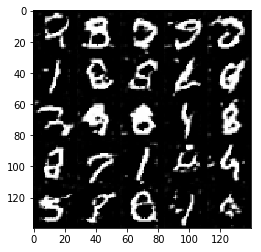

Epoch 2/2... Discriminator Loss: 0.4332... Generator Loss: 1.5360
Epoch 2/2... Discriminator Loss: 0.4449... Generator Loss: 1.4639
Epoch 2/2... Discriminator Loss: 0.4926... Generator Loss: 3.1701
Epoch 2/2... Discriminator Loss: 0.5523... Generator Loss: 3.3755
Epoch 2/2... Discriminator Loss: 0.3738... Generator Loss: 1.5731
Epoch 2/2... Discriminator Loss: 0.3773... Generator Loss: 1.8968
Epoch 2/2... Discriminator Loss: 0.3053... Generator Loss: 1.6767
Epoch 2/2... Discriminator Loss: 0.4587... Generator Loss: 1.2118
Epoch 2/2... Discriminator Loss: 0.5761... Generator Loss: 1.2037
Epoch 2/2... Discriminator Loss: 0.3794... Generator Loss: 1.7451


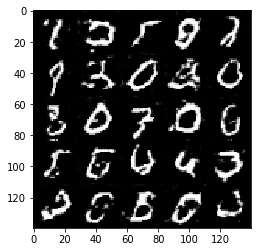

Epoch 2/2... Discriminator Loss: 0.4650... Generator Loss: 1.2630
Epoch 2/2... Discriminator Loss: 0.6395... Generator Loss: 3.3392
Epoch 2/2... Discriminator Loss: 0.4664... Generator Loss: 1.2961
Epoch 2/2... Discriminator Loss: 0.2798... Generator Loss: 2.1513
Epoch 2/2... Discriminator Loss: 0.6802... Generator Loss: 3.5012
Epoch 2/2... Discriminator Loss: 0.3940... Generator Loss: 2.9975
Epoch 2/2... Discriminator Loss: 0.5089... Generator Loss: 2.9930
Epoch 2/2... Discriminator Loss: 0.3551... Generator Loss: 1.5540
Epoch 2/2... Discriminator Loss: 0.3218... Generator Loss: 2.7605
Epoch 2/2... Discriminator Loss: 0.3489... Generator Loss: 1.6267


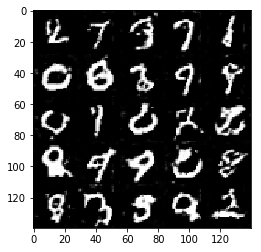

Epoch 2/2... Discriminator Loss: 0.2511... Generator Loss: 2.2071
Epoch 2/2... Discriminator Loss: 0.4132... Generator Loss: 2.8624
Epoch 2/2... Discriminator Loss: 0.4400... Generator Loss: 1.2908
Epoch 2/2... Discriminator Loss: 0.4461... Generator Loss: 3.3916
Epoch 2/2... Discriminator Loss: 0.8964... Generator Loss: 3.1413
Epoch 2/2... Discriminator Loss: 0.3915... Generator Loss: 2.0945
Epoch 2/2... Discriminator Loss: 0.2926... Generator Loss: 2.0918
Epoch 2/2... Discriminator Loss: 0.4174... Generator Loss: 1.2976
Epoch 2/2... Discriminator Loss: 0.5692... Generator Loss: 4.1918
Epoch 2/2... Discriminator Loss: 0.4254... Generator Loss: 1.3266


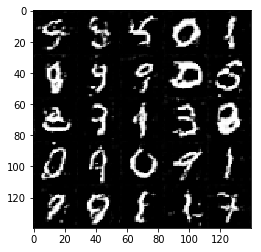

Epoch 2/2... Discriminator Loss: 0.4025... Generator Loss: 1.3615
Epoch 2/2... Discriminator Loss: 0.3262... Generator Loss: 1.8627
Epoch 2/2... Discriminator Loss: 0.2483... Generator Loss: 1.9907
Epoch 2/2... Discriminator Loss: 0.3366... Generator Loss: 1.5573
Epoch 2/2... Discriminator Loss: 0.3241... Generator Loss: 3.6030
Epoch 2/2... Discriminator Loss: 0.3180... Generator Loss: 1.5126
Epoch 2/2... Discriminator Loss: 0.3126... Generator Loss: 3.1799


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.0550
Epoch 1/1... Discriminator Loss: 0.5040... Generator Loss: 2.9901
Epoch 1/1... Discriminator Loss: 0.5714... Generator Loss: 3.4189
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 3.6294
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 1.9497
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 1.8938
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 2.1276
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.4433
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 2.0612


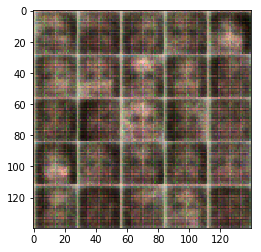

Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 2.2611
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 1.2221
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 2.2101
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 1.5775
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 1.5105
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 1.3165
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.5806... Generator Loss: 0.3435
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.6464


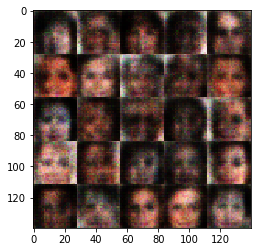

Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.4888
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.5836
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.4450
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 2.0106... Generator Loss: 0.2306
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.6605


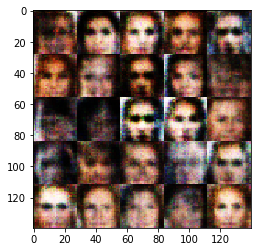

Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.4443
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.3697
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.3721
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.4520
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.4755
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.3996
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.5849


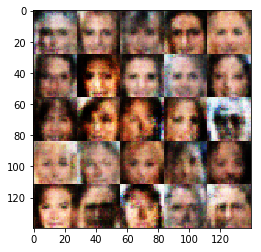

Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.4146
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.3570
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.4757


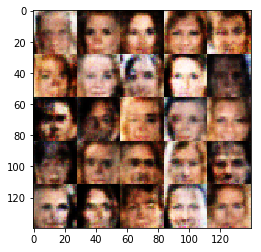

Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.4327
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.4650
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.4617
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.4244
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 1.8481
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 1.4115


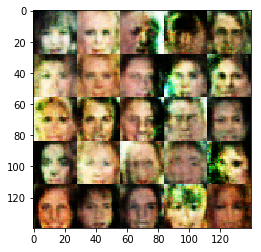

Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 1.9335
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.1556
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 1.3709
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 1.4274
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 1.3783
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 1.4837


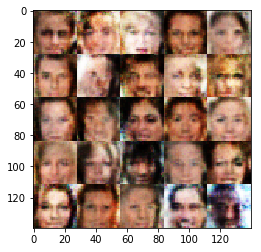

Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 1.4185
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 1.2858
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 1.1994
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 1.1452
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 1.4875
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 1.3025


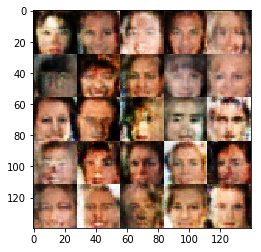

Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 1.0502
Epoch 1/1... Discriminator Loss: 1.5439... Generator Loss: 1.5453
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 1.2250
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 1.1465
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 1.1157
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.7579


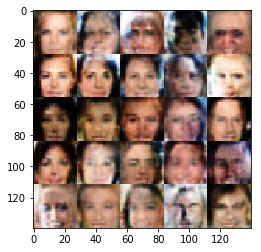

Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.4632
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 1.2461


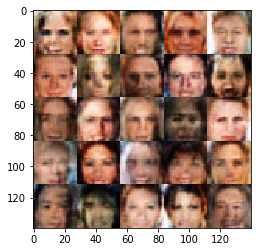

Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 1.4941
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 1.7520
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.7523


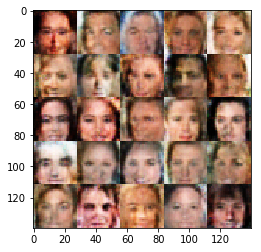

Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.5284
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.4990
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 1.2467
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 1.2585
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.9812


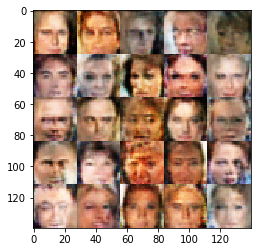

Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 1.1035
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 1.3139
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 1.3436
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.6250


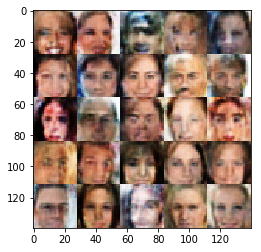

Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.5098
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.4831
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 1.0813
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 1.3566
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 1.0269


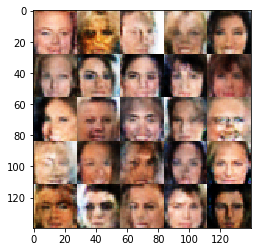

Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.3936
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.5422


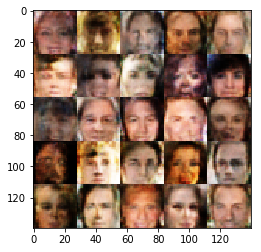

Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.5626
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.5757
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.5532


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.